## Binary classification problem

### Dataset :

We study first a binary classification problem, performed by a neural network. Each input has two real features, and the output can be only 0 or 1. The training set contains 4000 examples, and the validation set, 1000.

In [242]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Display figures on jupyter notebook
%matplotlib inline

In [243]:
# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi+1)*torch.cos(phi)
    y = phi*torch.sin(phi)
    return torch.cat((x, y), dim=1)

def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(0, 10)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.3)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data//2:,:] *= -1
    labels[num_data//2:] = 1
    return data, labels

In [65]:
# Generate the training set with 4000 examples by function generate_data

X_train, y_train = generate_data(4000)
X_train.size()

torch.Size([4000, 2])

In [66]:
# Define the vis_data function to visualize the dataset
def vis_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.plot(X[y==1, 0], X[y==1, 1], 'r+') #Examples are represented as red plusses for label 1
    plt.plot(X[y==0, 0], X[y==0, 1], 'b+') #Examples are represented as blue plusses for label 0 

We can now invoke the `vis_data` function on the dataset previously generated to see what it looks like:

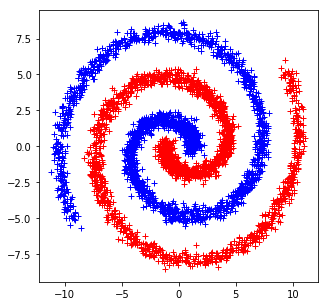

In [67]:
vis_data(X_train, y_train) # visualize training set

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

In [68]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(X_train, y_train)

###  Training the model with a neural network

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll work on to improve it during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [69]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just one layer. A useful tutorial for constructing model can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [188]:
# Basic network structure with a single layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        self.l1 = nn.Linear(2, 1)
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        outputs = torch.sigmoid(self.l1(inputs))
        return outputs

In [189]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

#### Training the defined model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [190]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [191]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)

Epoch [1/10], Loss: 0.2604
Epoch [2/10], Loss: 0.2413
Epoch [3/10], Loss: 0.2375
Epoch [4/10], Loss: 0.2356
Epoch [5/10], Loss: 0.2348
Epoch [6/10], Loss: 0.2342
Epoch [7/10], Loss: 0.2342
Epoch [8/10], Loss: 0.2339
Epoch [9/10], Loss: 0.2339
Epoch [10/10], Loss: 0.2337


Text(0.5, 1.0, 'Visualization of convergence')

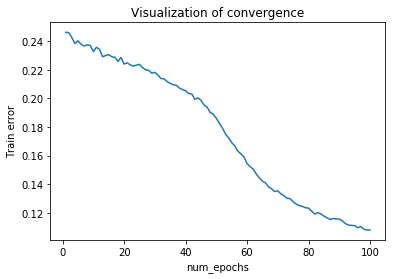

In [187]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

#### Evaluate the model on the validation set

In [81]:
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

In [82]:
# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)

In [83]:
# Calculate the accuracy on validation set to evaluate the model by the function accuracy
def accuracy(y_real, y_pre):
    y_pre[y_pre<0.5] = 0
    y_pre[y_pre>=0.5] = 1

    acc = 1 - torch.sum(torch.abs(y_pre - y_real))/len(y_pre)
    print('Accuracy of the network on the 1000 validation data: {:.2f} %'.format(acc.item()*100))

In [84]:
accuracy(y_val, y_pre)

Accuracy of the network on the 1000 validation data: 61.30 %


In [85]:
# Compare the prediction with real labels

def compare_pred(X, y_real, y_pre):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.plot(X[y_real==1, 0], X[y_real==1, 1], 'r+') #Examples are represented as a red plusses for label 1
    plt.plot(X[y_real==0, 0], X[y_real==0, 1], 'b+') #Examples are represented as a blue plusses for label 0
    plt.title("real data")

    plt.subplot(122)
    plt.plot(X[y_pre==1, 0], X[y_pre==1, 1], 'r+')
    plt.plot(X[y_pre==0, 0], X[y_pre==0, 1], 'b+')
    plt.title("prediciton results")

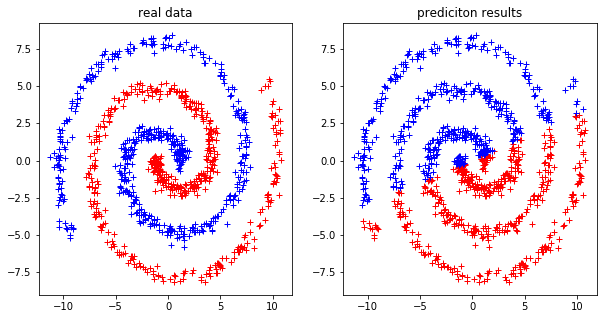

In [86]:
compare_pred(X_val, y_val, y_pre)

### Exercice 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try to different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)

We'll use nn.Sequential to build our neural networks more easily

In [132]:
from collections import OrderedDict
import time

We will use dictionnaries to call our activation, optimizer and criterion. 

In [259]:
activations = {'ReLU':nn.ReLU, 'Sigmoid':nn.Sigmoid, 'Tanh':nn.Tanh}
optimizers = {'SGD':torch.optim.SGD, 'Adam':torch.optim.Adam, 'RMS':torch.optim.RMSprop}
criterions = {'MSE':torch.nn.MSELoss, 'BCELog':torch.nn.BCEWithLogitsLoss}

For an unknown reason, the dictionnary is unable to call the right optimi

[Parameter containing:
 tensor([[ 0.0761, -0.1195]], requires_grad=True), Parameter containing:
 tensor([0.0127], requires_grad=True)]

In [293]:
optimizer = optimizers["Adam"](model.parameters(), lr=0.01)

In [154]:
nb_iterations, batch_size = 100, 10

### On fera au minimum 2 couches

We define a build and train functions that will return the training error, based on the parameters input

In [299]:
def build_and_train(nb_layers, activation, nb_neurons, optimizer, criterion, lr):
    
    global training_set, nb_iterations, batch_size
    
    start = time.time()
        
    parameters = [('linear1', nn.Linear(2, nb_neurons)), (activation+'1', activations[activation]())]
    for k in range(2, nb_layers):
        parameters.append(('linear' + str(k), nn.Linear(nb_neurons, nb_neurons)))
        parameters.append((activation + str(k), activations[activation]()))
    parameters.append(('linear' + str(nb_layers), nn.Linear(nb_neurons, 1)))
    #  parameters.append((activation + str(nb_layers), activations[activation]()))
    parameters = OrderedDict(parameters)
    
    model = nn.Sequential(parameters)
    
    criterion = criterions[criterion]()
    optimizer = optimizers[optimizer](model.parameters(), lr)

    
    train_error = []
    train_loader = DataLoader(training_set, batch_size, shuffle=True)
    model.train()
    for epoch in range(nb_iterations):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(training_set)
        train_error.append(epoch_average_loss)
        
    end = time.time()    
    duration = end - start
    
    return train_error, duration, model.parameters

In [317]:
opt = optimizers["Adam"](model.parameters(), lr)

In [169]:
# Combinations of nb_layers and nb_neurons we will try

params = [(2, 20), (2,100), (3, 20), (3, 50), (3, 100), (4, 20), (4, 50), (4, 100)]

training_errors = dict()
durations = dict()
model_parameters = dict()

In [170]:
for nums in params:
    k, l = nums
    loss, duration, model_params = build_and_train(k, 'Sigmoid', l, "SGD", "MSE", 0.01)
    training_errors["{} layers, {} neurons".format(k, l)] = loss
    durations["{} layers, {} neurons".format(k, l)] = duration
    model_parameters["{} layers, {} neurons".format(k, l)] = model_params

In [171]:
from numpy import *
import math
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Using Sigmoid, MSE and SGD')

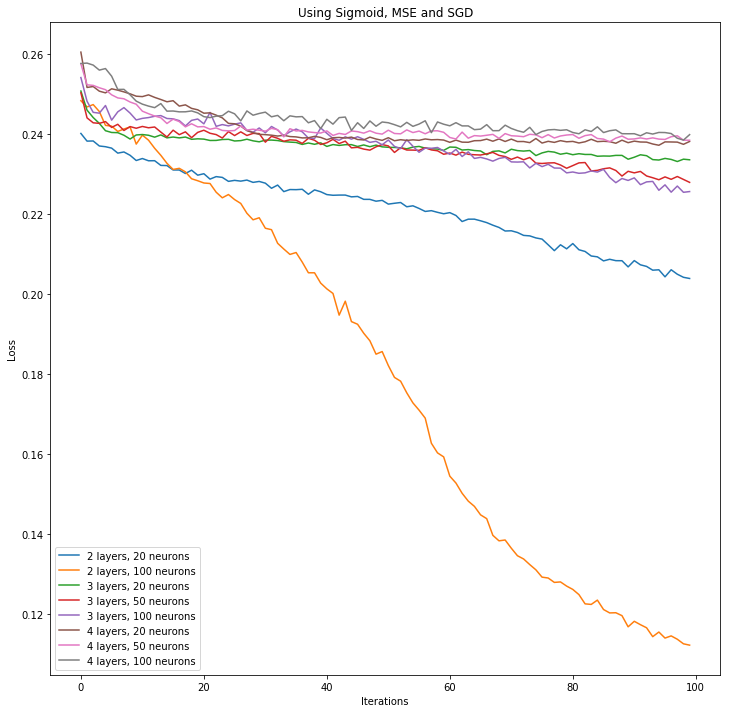

In [227]:
fig, ax = plt.subplots(figsize=(12,12))
for i, key in enumerate(training_errors.keys()):
    ax.plot(training_errors[key], label = key)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.set_title("Using Sigmoid, MSE and SGD")

Text(0.5, 1.0, 'Using Sigmoid, MSE and SGD')

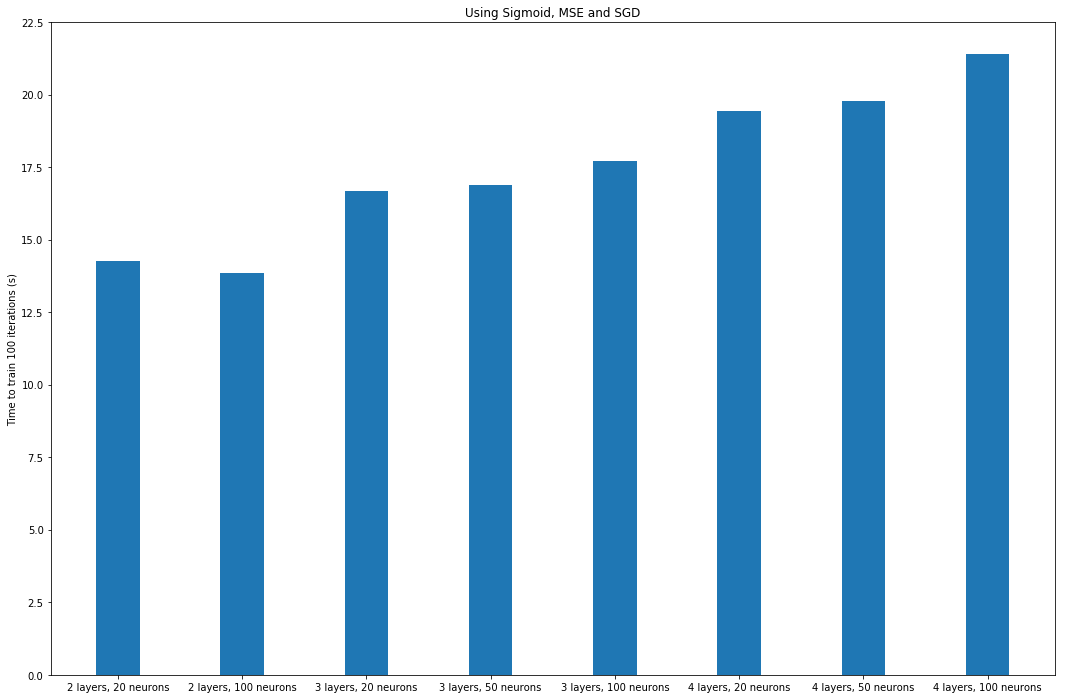

In [228]:
fig, ax = plt.subplots(figsize=(18,12))
a = list(durations.keys())
b = list(durations.values())
N = len(a)
ind = np.arange(N)
plt.bar(ind,  b, width = 0.35)
plt.xticks(ind, a)
ax.set_ylabel("Time to train 100 iterations (s)")
ax.set_title("Using Sigmoid, MSE and SGD")

Keeping the Sigmoid activation function, we observe it is preferable to have enough neurons (100), but not too many layers, as the loss function gets stuck. 
Let's try now with Tanh and ReLU if this changes. We will start with Tanh

In [229]:
# Combinations of nb_layers and nb_neurons we will try

params = [(2, 20), (2,100), (3, 20), (3, 50), (3, 100), (4, 20), (4, 50), (4, 100)]

training_errors = dict()
durations = dict()
model_parameters = dict()

In [230]:
for nums in params:
    k, l = nums
    loss, duration, model_params = build_and_train(k, 'Tanh', l, "SGD", "MSE", 0.01)
    training_errors["{} layers, {} neurons".format(k, l)] = loss
    durations["{} layers, {} neurons".format(k, l)] = duration
    model_parameters["{} layers, {} neurons".format(k, l)] = model_params

Text(0.5, 1.0, 'Using Tanh, MSE and SGD')

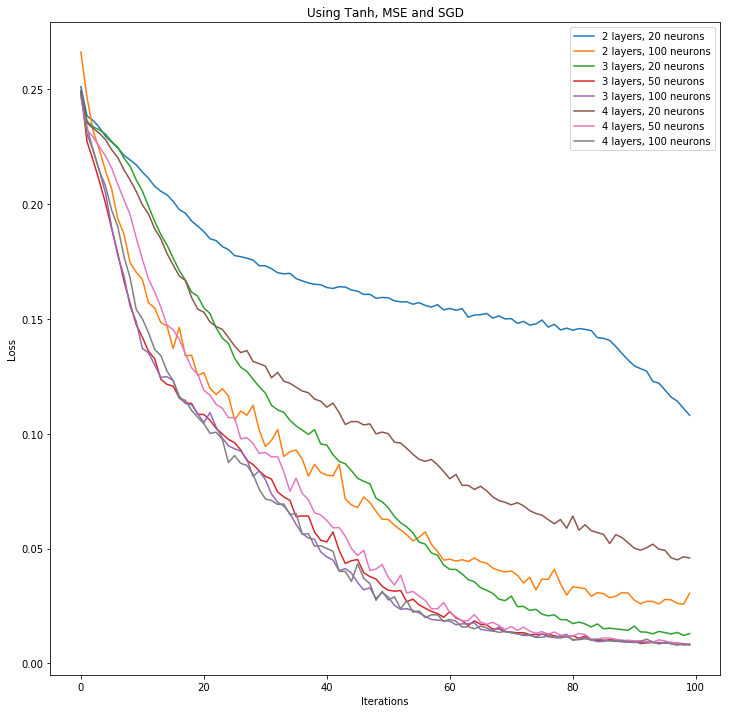

In [231]:
fig, ax = plt.subplots(figsize=(12,12))
for i, key in enumerate(training_errors.keys()):
    ax.plot(training_errors[key], label = key)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.set_title("Using Tanh, MSE and SGD")

Text(0.5, 1.0, 'Using Tanh, MSE and SGD')

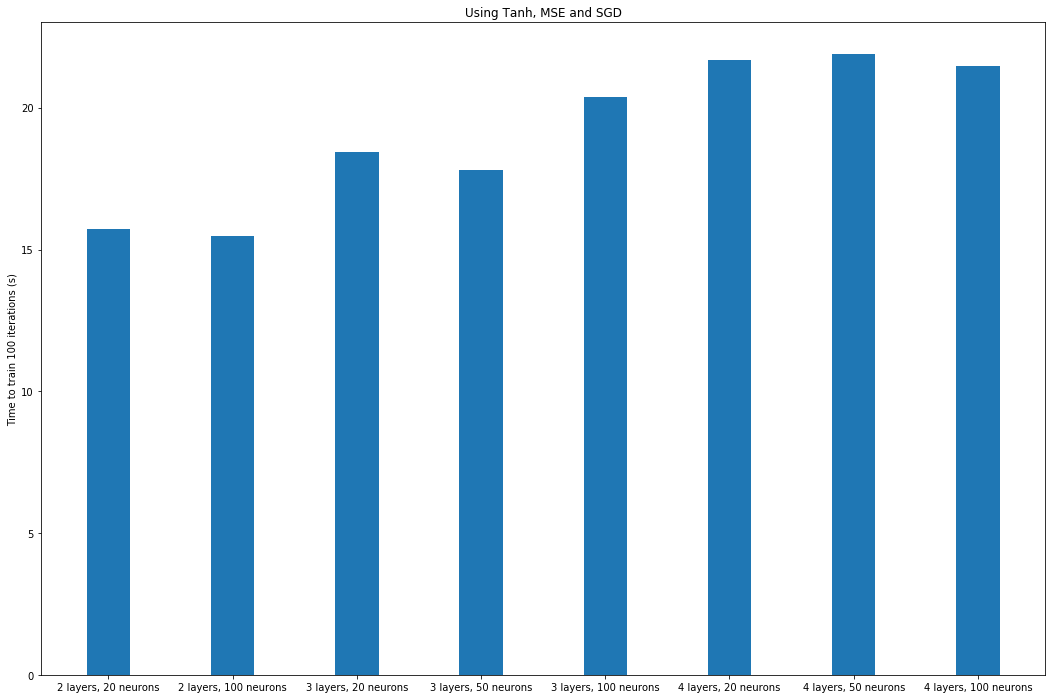

In [232]:
fig, ax = plt.subplots(figsize=(18,12))
a = list(durations.keys())
b = list(durations.values())
N = len(a)
ind = np.arange(N)
plt.bar(ind,  b, width = 0.35)
plt.xticks(ind, a)
ax.set_ylabel("Time to train 100 iterations (s)")
ax.set_title("Using Tanh, MSE and SGD")

In [239]:

# Combinations of nb_layers and nb_neurons we will try

params = [(2, 20), (2,100), (3, 20), (3, 50), (3, 100), (4, 20), (4, 50), (4, 100)]

training_errors = dict()
durations = dict()
model_parameters = dict()

nb_iterations = 30

for nums in params:
    k, l = nums
    loss, duration, model_params = build_and_train(k, 'ReLU', l, "SGD", "MSE", 0.01)
    training_errors["{} layers, {} neurons".format(k, l)] = loss
    durations["{} layers, {} neurons".format(k, l)] = duration
    model_parameters["{} layers, {} neurons".format(k, l)] = model_params

Text(0.5, 1.0, 'Using ReLU, MSE and SGD')

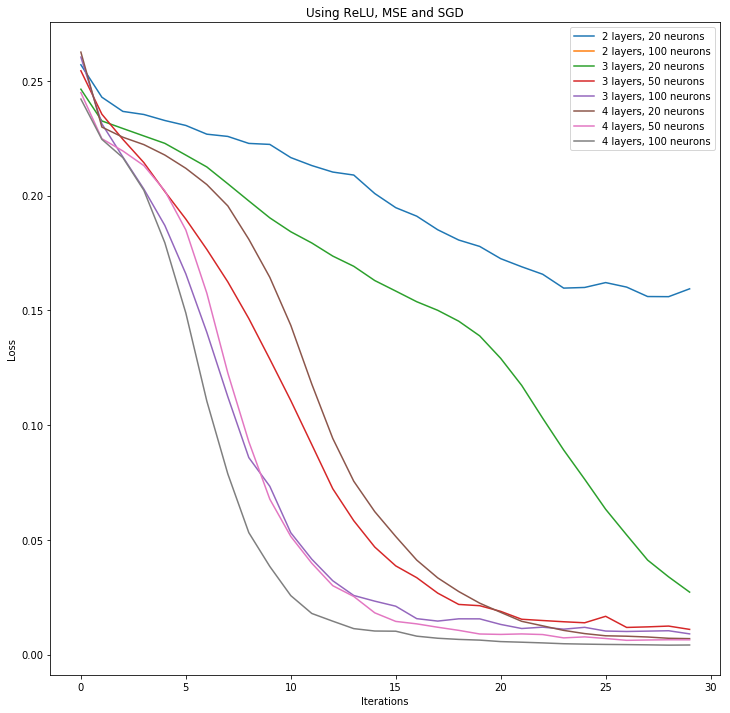

In [240]:
fig, ax = plt.subplots(figsize=(12,12))
for i, key in enumerate(training_errors.keys()):
    ax.plot(training_errors[key], label = key)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.set_title("Using ReLU, MSE and SGD")

Text(0.5, 1.0, 'Using ReLU, MSE and SGD')

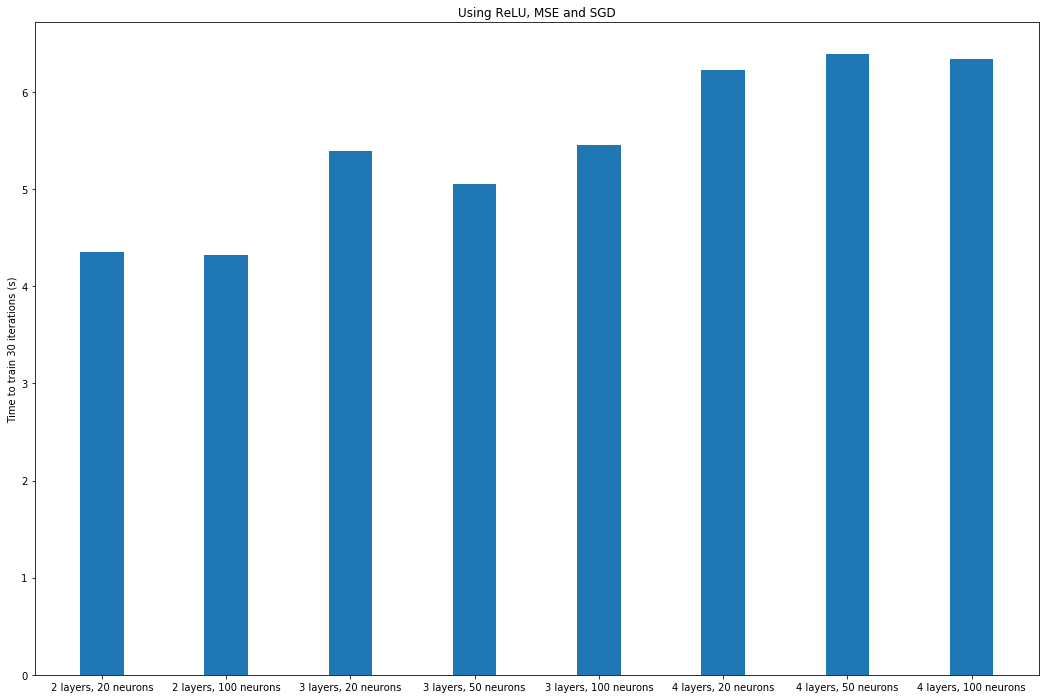

In [241]:
fig, ax = plt.subplots(figsize=(18,12))
a = list(durations.keys())
b = list(durations.values())
N = len(a)
ind = np.arange(N)
plt.bar(ind,  b, width = 0.35)
plt.xticks(ind, a)
ax.set_ylabel("Time to train 30 iterations (s)")
ax.set_title("Using ReLU, MSE and SGD")

With ReLU and Tanh activation functions, it is preferable to use more layers and more neurons per layer. 
Eventually, networks with 100 neurons and 3-4 layers converged towards a Loss of 0. Howerver, this was achieved quicker with 4 layers. 
We can't draw a parallel for the number of neurons: for a given number of layers, having more neurons was more efficient for ReLU, but not for Tanh
The networks with 4 layers and 100 neurons per layers outperformed the others. 
In parallel, we observe ReLU is more efficient than Tanh, which is more efficient than Sigmoid. It addition to converging towards the same loss than Tanh, it starts converging much sooner (~15 iterations vs 60 iterations). Best model was achieved by having more layers (4), more neurons (100) and ReLU activation. 

### Exercice 2: Impact of the optimizer

Retrain the model by using different parameters of the optimizer, you can change its parameter in the cell initializing it, after the definition of your model.

* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the trainig process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

we will start with the most efficient model we found before : 4 layers, 100 neurons and ReLU
Default learning rates is 0.01 for SGD and RMSpop. It is 0.001 for Adam optimizer.

Let us start with SGD, with the learning rates below

In [333]:
lr = [0.005, 0.01, 0.05, 0.1, 1]

In [334]:
training_errors = dict()
durations = dict()
model_parameters = dict()

nb_iterations = 30

for l in lr:
    for opt in ["SGD"]:
        loss, duration, model_params = build_and_train(4, 'ReLU', 100, opt, "MSE", l)
        training_errors["4 layers, 100 neurons, {} optimizer with a learning rate of {}".format(opt, l)] = loss
        durations["4 layers, 100 neurons, {} optimizer with a learning rate of {}".format(opt, l)] = duration
        model_parameters["4 layers, 100 neurons, {} optimizer with a learning rate of {}".format(opt, l)] = model_params

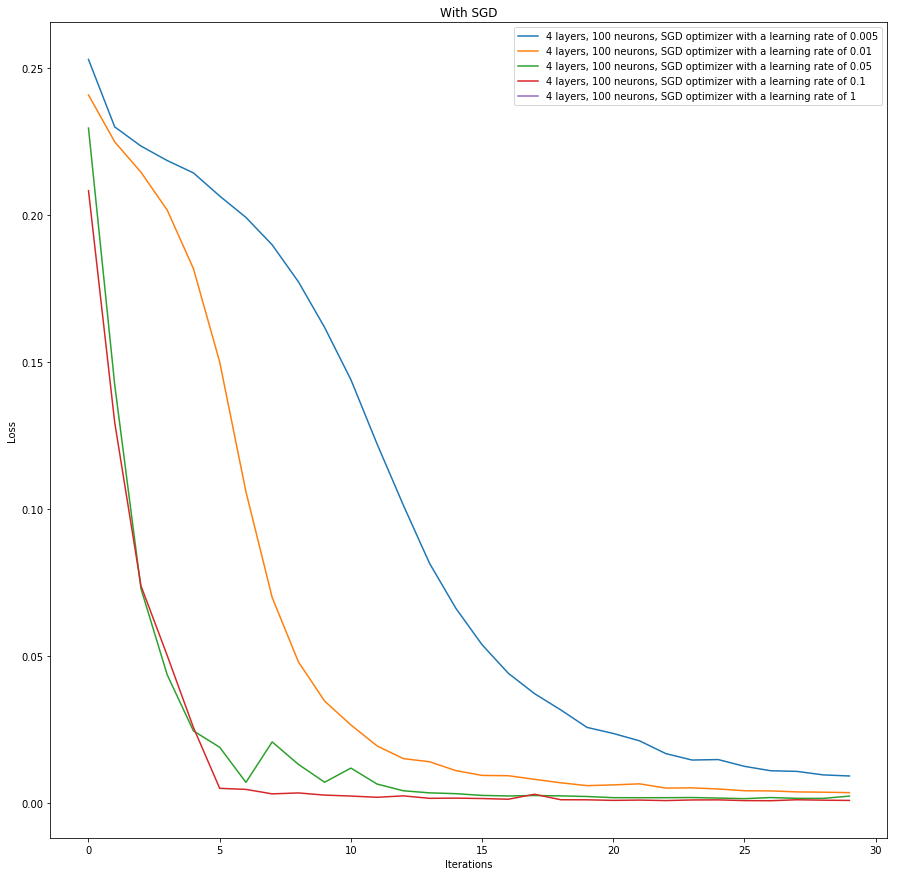

In [336]:
fig, ax = plt.subplots(figsize=(15,15))
for i, key in enumerate(training_errors.keys()):
    ax.plot(training_errors[key], label = key)
ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.set_title("With SGD")
ax.legend()

A learning rate of 1 is too important. 
A learning rate of 0.005 or 0.01 is too slow 
Best learning rate is 0.1, and convergence is reached at the 5th iteration. 
Let's try now with Tanh

In [353]:
lr = [0.0005, 0.001, 0.005, 0.01, 0.05]
training_errors = dict()
durations = dict()
model_parameters = dict()

nb_iterations = 30

for l in lr:
    for opt in ["RMS"]:
        loss, duration, model_params = build_and_train(4, 'ReLU', 100, opt, "MSE", l)
        training_errors["4 layers, 100 neurons, {} optimizer with a learning rate of {}".format(opt, l)] = loss
        durations["4 layers, 100 neurons, {} optimizer with a learning rate of {}".format(opt, l)] = duration
        model_parameters["4 layers, 100 neurons, {} optimizer with a learning rate of {}".format(opt, l)] = model_params

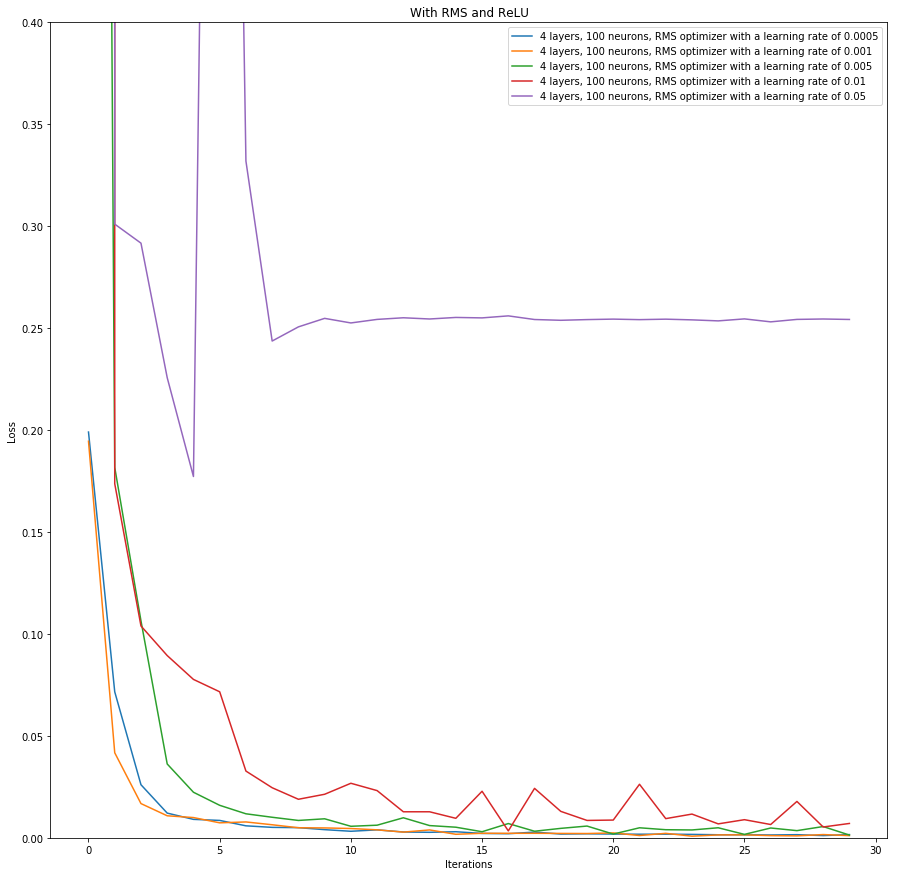

In [354]:
fig, ax = plt.subplots(figsize=(15,15))
for i, key in enumerate(training_errors.keys()):
    ax.plot(training_errors[key], label = key)
ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.set_title("With RMS and ReLU")
plt.ylim((0,0.4))
ax.legend()

Convergence is achieved even sooner (3-4 iterations) with lr = 0.0005 or lr = 0.001
We shall try with other model architectures and activation functions

In [355]:
lr = [0.005, 0.01, 0.05, 0.1, 1]
training_errors = dict()
durations = dict()
model_parameters = dict()

nb_iterations = 30

for l in lr:
    for opt in ["Adam"]:
        loss, duration, model_params = build_and_train(4, 'ReLU', 100, opt, "MSE", l)
        training_errors["4 layers, 100 neurons, {} optimizer with a learning rate of {}".format(opt, l)] = loss
        durations["4 layers, 100 neurons, {} optimizer with a learning rate of {}".format(opt, l)] = duration
        model_parameters["4 layers, 100 neurons, {} optimizer with a learning rate of {}".format(opt, l)] = model_params

(0, 0.4)

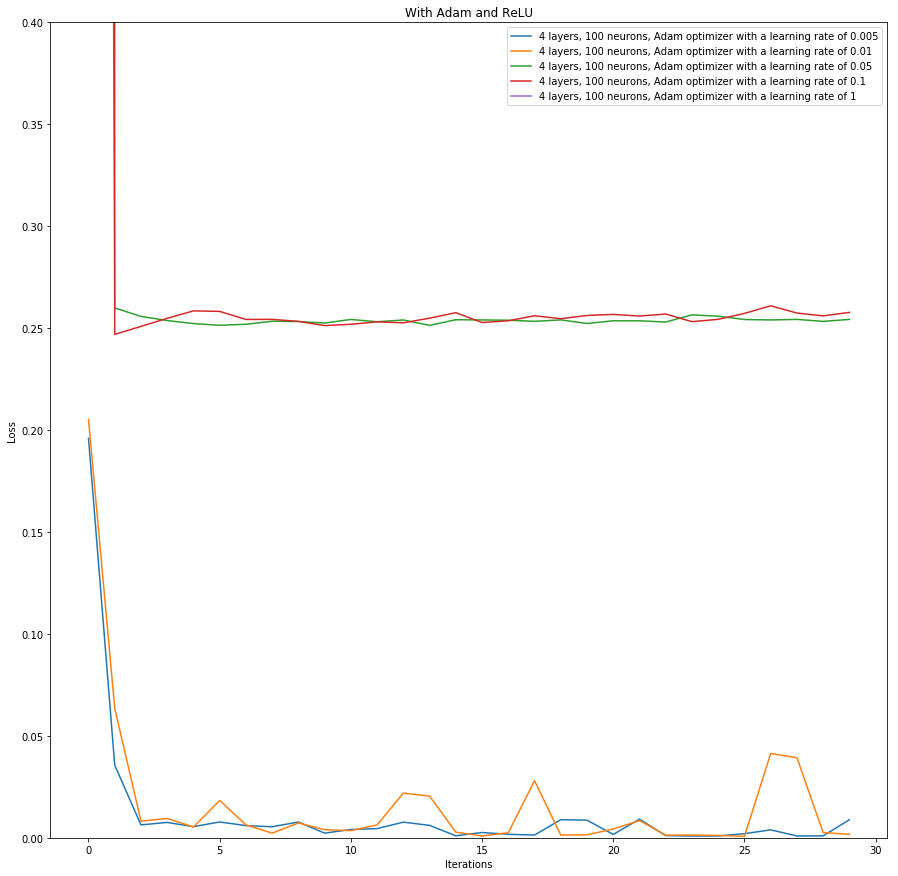

In [357]:
fig, ax = plt.subplots(figsize=(15,15))
for i, key in enumerate(training_errors.keys()):
    ax.plot(training_errors[key], label = key)
ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.set_title("With Adam and ReLU")
ax.legend()
plt.ylim((0,0.4))

With Adam optimizer, a learning rate of 0.005 or 0.01 is preferable. 
A learning rate more important is too high and doesn't enable convergence. 

Let us now try with 2 layers and 100 neurons per layer. 

In [349]:
lr = [0.0005, 0.001, 0.005]
training_errors = dict()
durations = dict()
model_parameters = dict()

nb_iterations = 30
opt = "RMS"

params = [(2,100)]


for l in lr:
    for nums in params:
        for act in ["ReLU", "Sigmoid", "Tanh"]:
            a, b = nums
            loss, duration, model_params = build_and_train(a, act, b, opt, "MSE", l)
            training_errors["{} layers, {} neurons, {} activation ,{} optimizer with a learning rate of {}".format(a, b, act, opt, l)] = loss
            durations["{} layers, {} neurons, {} activation ,{} optimizer with a learning rate of {}".format(a, b, act, opt, l)] = duration
            model_parameters["{} layers, {} neurons, {} activation ,{} optimizer with a learning rate of {}".format(a, b, act, opt, l)] = model_params

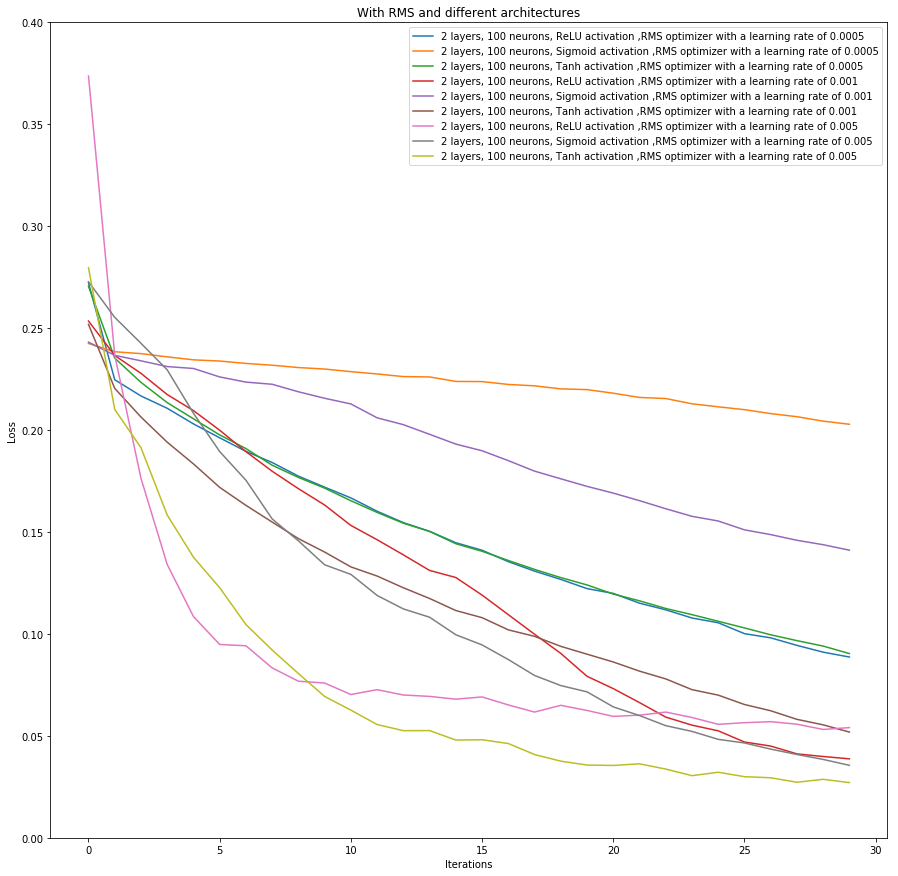

In [350]:
fig, ax = plt.subplots(figsize=(15,15))
for i, key in enumerate(training_errors.keys()):
    ax.plot(training_errors[key], label = key)
ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.set_title("With RMS and different architectures")
plt.ylim((0,0.4))
ax.legend()

Like we saw before, Tanh and ReLU activations are more efficient than Sigmoid. However, a learning rate of 0.005, which is much higher than with 4 layers, as we so above. 

### Exercice 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

We will try different combinations of architechtures, each time comparing MSE with BCELogit.

These architectures will be tested :
- 2 layers, 50 neurons, ReLU - Tanh, Adam
- 3 layers, 80 neurons, ReLU - Tanh, Adam
- 4 layers, 100 neurons, ReLU - Tanh, Adam

In [363]:
criterions["BCELog"]()

BCEWithLogitsLoss()

In [366]:
lr = [0.01]
training_errors = dict()
durations = dict()
model_parameters = dict()

nb_iterations = 30


params = [(2,50), (3,80), (4,100)]


for l in lr:
    for lo in ["MSE", "BCELog"]:
        for nums in params:
            for opt in ["Adam"]:
                for act in ["ReLU"]:
                    a, b = nums
                    loss, duration, model_params = build_and_train(a, act, b, opt, lo, l)
                    training_errors["{} layers, {} neurons, {} activation ,{} optimizer with a learning rate of {}, and {} as loss".format(a, b, act, opt, l, lo)] = loss
                    durations["{} layers, {} neurons, {} activation ,{} optimizer with a learning rate of {}, and {} as loss".format(a, b, act, opt, l, lo)] = duration
                    model_parameters["{} layers, {} neurons, {} activation ,{} optimizer with a learning rate of {}, and {} as loss".format(a, b, act, opt, l, lo)] = model_params

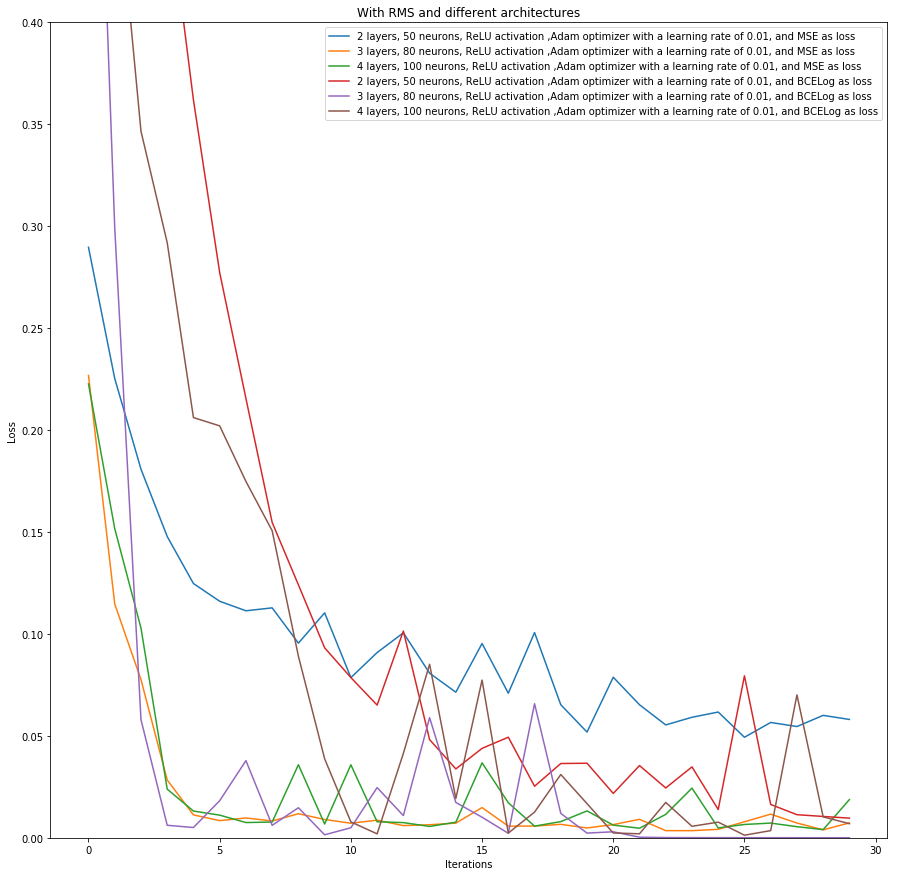

In [367]:
fig, ax = plt.subplots(figsize=(15,15))
for i, key in enumerate(training_errors.keys()):
    ax.plot(training_errors[key], label = key)
ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.set_title("With RMS and different architectures")
plt.ylim((0,0.4))
ax.legend()

### Exercice 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [368]:
# Here is a test dataset. Use it similarly to the validaiton dataset above
# to compute the final performance of your model
X_test, y_test = generate_data(500)

In [369]:
def build_and_train(nb_layers, activation, nb_neurons, optimizer, criterion, lr):
    
    global training_set, nb_iterations, batch_size
        
    parameters = [('linear1', nn.Linear(2, nb_neurons)), (activation+'1', activations[activation]())]
    for k in range(2, nb_layers):
        parameters.append(('linear' + str(k), nn.Linear(nb_neurons, nb_neurons)))
        parameters.append((activation + str(k), activations[activation]()))
    parameters.append(('linear' + str(nb_layers), nn.Linear(nb_neurons, 1)))
    #  parameters.append((activation + str(nb_layers), activations[activation]()))
    parameters = OrderedDict(parameters)
    
    model = nn.Sequential(parameters)
    
    criterion = criterions[criterion]()
    optimizer = optimizers[optimizer](model.parameters(), lr)

    
    train_error = []
    train_loader = DataLoader(training_set, batch_size, shuffle=True)
    model.train()
    for epoch in range(nb_iterations):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(training_set)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    
    return model

In [370]:
model = build_and_train(4, "ReLU", 100, "Adam", "MSE", 0.001)

Epoch [1/10], Loss: 0.1996
Epoch [2/10], Loss: 0.0543
Epoch [3/10], Loss: 0.0126
Epoch [4/10], Loss: 0.0066
Epoch [5/10], Loss: 0.0048
Epoch [6/10], Loss: 0.0034
Epoch [7/10], Loss: 0.0031
Epoch [8/10], Loss: 0.0041
Epoch [9/10], Loss: 0.0030
Epoch [10/10], Loss: 0.0050
Epoch [11/10], Loss: 0.0016
Epoch [12/10], Loss: 0.0018
Epoch [13/10], Loss: 0.0017
Epoch [14/10], Loss: 0.0048
Epoch [15/10], Loss: 0.0051
Epoch [16/10], Loss: 0.0034
Epoch [17/10], Loss: 0.0015
Epoch [18/10], Loss: 0.0013
Epoch [19/10], Loss: 0.0012
Epoch [20/10], Loss: 0.0022
Epoch [21/10], Loss: 0.0011
Epoch [22/10], Loss: 0.0011
Epoch [23/10], Loss: 0.0016
Epoch [24/10], Loss: 0.0024
Epoch [25/10], Loss: 0.0010
Epoch [26/10], Loss: 0.0045
Epoch [27/10], Loss: 0.0020
Epoch [28/10], Loss: 0.0006
Epoch [29/10], Loss: 0.0008
Epoch [30/10], Loss: 0.0012


In [371]:
# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)

In [372]:
accuracy(y_val, y_pre)

Accuracy of the network on the 1000 validation data: 100.00 %


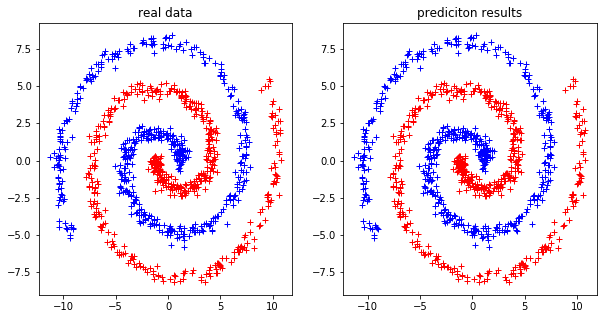

In [374]:
compare_pred(X_val, y_val, y_pre)